# **Using Time of Day to Predict the Number of Simultaneous PLAIcraft Players: A KNN regression Analysis**

## **Introduction**
PLAICraft is a Minecraft server created by the Pacific Laboratory for Artificial Intelligence (PLAI) which serves as a research platform for studying the applications of artificial intelligence in the context of video games. However, managing this large-scale project is not a straightforward task: one key issue that the PLAI research team faces is ensuring that they have a sufficient number of licenses and the proper server hardware to accommodate a growing number of players.

Therefore, the objective of this DSCI100 project is to use PLAICraft data to predict the usage of the server in order to understand factors influencing player behavior and server load. Specifically, this project aims to investigate the following research question:  

*Can time of day accurately predict the number of simultaneous PLAIcraft players using KNN regression?*

KNN regression is a predictive tool that uses the K-nearest neighbours algorithm to predict a numerical response variable value for a new observation based on the values of the response variable for similar observations in a data set of past observations. In regression, the response variable is a numeric target outcome that is influenced by one or more explanatory variables, which are inputs used to make predictions about the response variable. 

Time of day was selected as the one explanatory variable of interest in this project because it is most directly associated with the PLAI researchers' overarching goal of determining what time windows are most likely to have largest numbers of concurrent players. The response variable, number of simultaneous PLAIcraft players, is a measure that reflects player demand at any given time of day and serves as an indicator of the required server capacity and licenses. 

In order to effectively address our research question, it is important to understand the structure and content of the PLAIcraft data. 
The PLAIcraft data consists of two files: players.csv and sessions.csv.

**Table 1. players.csv (196 observations, 9 variables)**
|Variable | Variable type | Description | Issues|
|---|---|---|---|
|experience|chr|Self-ranked Minecraft skill level|Should be “fct" data type, players may overestimate/underestimate skill level<br>★| 
|subscribe|lgl|Whether player subscribed for server activity email updates| Players may have device notifications disabled|
|hashedEmail|chr|Account email in hashed format|One player may sign-up multiple times using different emails|
|played_hours|dbl|Total gameplay hours|Includes “away-from-keyboard” time|
|name|chr|Player username|N/A|
|gender|chr|Gender identity|Should be “fct” data type <br>★|
|age|dbl|Age in years|Only ages 7-99 can participate <br>★|
|individualID|lgl|Unique player identifier for anonymous data tracking|Data missing, cannot analyze|
|organizationName|lgl|Name of organization player is affiliated with|Data missing, cannot analyze|

★ Players may answer dishonestly or answers may not reflect changes made since their account creation.<br><br>

**Table 2. sessions.csv (1535 observations, 5 variables)**
|Variable Name|Variable type|Description|Potential Issues|
|---|---|---|---|
|hashedEmail|chr|Account email in hashed format|One player may sign-up multiple times using different emails|
|start_time|chr|Timestamp, player logging into PLAIcraft (day:month:year  hour:minute:second)|Not tidy, improper data type|
|end_time|chr|Timestamp, player exiting PLAIcraft (day:month:year  hour:minute:second)|Same as start_time|
|original_start_time|dbl|Start time, UNIX timestamp format|Not easily human readable, limited precision|
|original_end_time|dbl|End time, UNIX timestamp format|Same as original_start_time|

## **Methods and Results**

#### **Loading the entire dataset**
In order to download and work with the data, we must first load all necessary libraries:

In [6]:
library(tidyverse)
library(repr)
library(lubridate)
library(tidymodels)

Next, we must demonstrate that the entire data set can be loaded into R:

In [5]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(players_url)
players_data

sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(sessions_url)
sessions_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,NA,NA
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15/04/2024 07:12,15/04/2024 07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21/09/2024 02:13,21/09/2024 02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21/06/2024 02:31,21/06/2024 02:49,1.71894e+12,1.71894e+12


The players.csv file contains information that is not directly relevant to our specific research question. Hence, we will not continue tidying or wrangling the data in this file.

For the purposes of our analysis, we will focus solely on the sessions.csv file. This file contains the key start time and end time variables that we need in order to assess what times of day have the most active PLAIcraft players. 

#### **Tidying and wrangling the sessions.csv data**
To tidy and wrangle the sessions.csv data, we must first select the relevant variables: “start_time” and “end_time”. We are not considering “original_start_time” and “original_end_time” as these UNIX timestamps lack precision in comparison to “start_time” and “end_time”. We are also excluding “hashedEmail” as we are not analyzing individual player data.


In [149]:
session_time <- sessions_data |>
    select(start_time, end_time)
session_time

start_time,end_time
<chr>,<chr>
30/06/2024 18:12,30/06/2024 18:24
17/06/2024 23:33,17/06/2024 23:46
25/07/2024 17:34,25/07/2024 17:57
25/07/2024 03:22,25/07/2024 03:58
25/05/2024 16:01,25/05/2024 16:12
23/06/2024 15:08,23/06/2024 17:10
15/04/2024 07:12,15/04/2024 07:21
21/09/2024 02:13,21/09/2024 02:30
21/06/2024 02:31,21/06/2024 02:49


Next, we must convert these timestamp variables to standard “dttm” format in order to apply mathematical functions to them later in our wrangling. We must also omit any observations where the time data is missing (NA).

In [150]:
dttm_session_time <- session_time |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
           end_time = as.POSIXct(end_time,format = "%d/%m/%Y %H:%M")) |>
    drop_na(start_time, end_time) 

dttm_session_time

start_time,end_time
<dttm>,<dttm>
2024-06-30 18:12:00,2024-06-30 18:24:00
2024-06-17 23:33:00,2024-06-17 23:46:00
2024-07-25 17:34:00,2024-07-25 17:57:00
2024-07-25 03:22:00,2024-07-25 03:58:00
2024-05-25 16:01:00,2024-05-25 16:12:00
2024-06-23 15:08:00,2024-06-23 17:10:00
2024-04-15 07:12:00,2024-04-15 07:21:00
2024-09-21 02:13:00,2024-09-21 02:30:00
2024-06-21 02:31:00,2024-06-21 02:49:00


Now we must pivot the data to categorize each timestamp as either an "entry" or "exit" based on whether a player is starting or ending their gameplay.

In [153]:
player_actions <- dttm_session_time |>
    pivot_longer(cols = c(start_time, end_time),
                names_to = "action",
                values_to = "time") |>

    mutate(action = case_when(
              action == "start_time" ~ "entry",
              action == "end_time" ~ "exit"))

player_actions 

action,time
<chr>,<dttm>
entry,2024-06-30 18:12:00
exit,2024-06-30 18:24:00
entry,2024-06-17 23:33:00
exit,2024-06-17 23:46:00
entry,2024-07-25 17:34:00
exit,2024-07-25 17:57:00
entry,2024-07-25 03:22:00
exit,2024-07-25 03:58:00
entry,2024-05-25 16:01:00


Afterwards, we can use group_by() and summarize() to count the number of occurrences of both actions (entry or exit) at each time point.

With this information, we can to find the running total number of players at each timestamp.

In [154]:
active_player_counts <- player_actions |>

    group_by(time, action) |>
    summarize(count = n(), .groups = "drop") |>

    # Finding running total number of players at each timestamp
    pivot_wider(names_from = action, 
                values_from = count,
                values_fill = 0) |>
    mutate(total_active_players = cumsum(entry) - cumsum(exit))

active_player_counts

time,entry,exit,total_active_players
<dttm>,<int>,<int>,<int>
2024-04-06 09:27:00,1,0,1
2024-04-06 09:31:00,0,1,0
2024-04-06 09:35:00,1,0,1
2024-04-06 10:16:00,0,1,0
2024-04-06 20:56:00,1,0,1
2024-04-06 22:04:00,0,1,0
2024-04-06 22:24:00,1,0,1
2024-04-06 23:33:00,0,1,0
2024-04-07 00:17:00,1,0,1


Finally, we can extract the hours, minutes, and seconds from the timestamps ("time" column) and convert it to a new variable: "time_in_hours_past_midnight".

In [155]:
player_counts_by_time <- active_player_counts |>
    mutate(hour = hour(time),
           minute_in_hours = minute(time)/60,
           second_in_hours = second(time)/3600,
                                          
           time_in_hours_past_midnight = hour + minute_in_hours + second_in_hours) |>

    select(time_in_hours_past_midnight, total_active_players)

player_counts_by_time

time_in_hours_past_midnight,total_active_players
<dbl>,<int>
9.4500000,1
9.5166667,0
9.5833333,1
10.2666667,0
20.9333333,1
22.0666667,0
22.4000000,1
23.5500000,0
0.2833333,1


The data is now in a tidy, wrangled format and ready for visualization.

#### **Visualizing Total Active Player Counts by Time of Day**

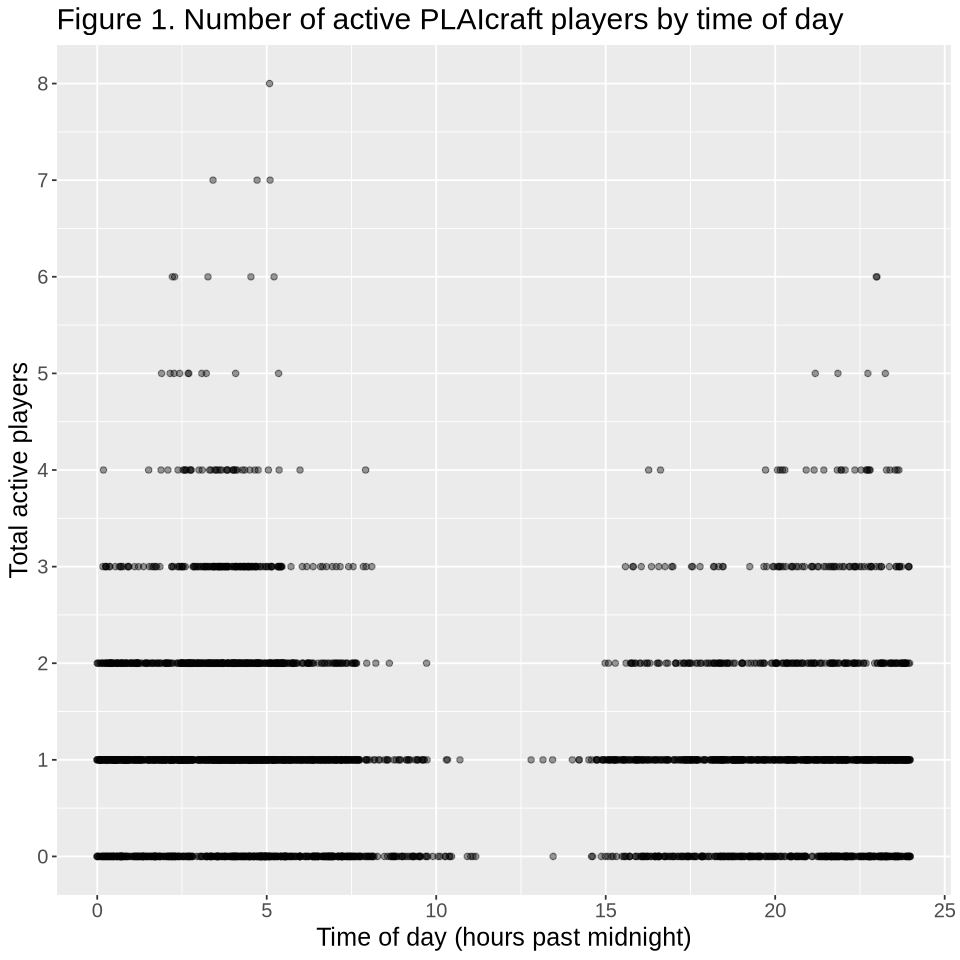

In [117]:
options(repr.plot.width = 8, repr.plot.height = 8)

sessions_plot <- player_counts_by_time |>
    ggplot(aes(x = time_in_hours_past_midnight, y = total_active_players)) +
    geom_point(alpha = 0.4) +
    labs(x = "Time of day (hours past midnight)",
         y = "Total active players",
         title = "Figure 1. Number of active PLAIcraft players by time of day") +
    scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
    theme(text = element_text(size = 15))
 
sessions_plot

The plot shows a strong cyclical pattern: active player count is generally highest late at night/very early in morning with peaks between ~2.5-6 and ~20-23 hours past midnight. The least amount of players are present 10-15 hours past midnight. Due to overplotting, we are unable to visually distinguish between the data points for the lower player counts betwneen ~0-8 and ~15-23 hours past midnight.

#### **Choosing the predictive model**
Given numerical nature of our response variable, total active players, and non-linear relationship observed in the data, we determined that KNN regression was the most appropriate predictive method for this analysis.

While KNN classification is suited for categorical predictions, KNN regression is specifically designed for predicting numerical values. Furthermore, whereas linear regression assumes a linear relationship between the predictor and response variables, KNN regression makes few assumptions about the structure of the data.

#### **KNN Regression Analysis**

Before beginning with our analysis, we must set the seed to ensure the reproducibility of our results.

In [121]:
#Part 0: Setting Seed value for reproducibility 
set.seed(1)

First, we must split the "player_counts_by_time" data frame into training and test sets, respectively. We chose to allocate 70% of the datta for training and 30% for testing. The training set will allow our model to learn the patterns in the data, while the test set will help us evaluate the model's performance on unseen data.

In [122]:
#Part 1: Splitting player_counts_by_time data frame into training and test sets
player_counts_by_time_split <- initial_split(player_counts_by_time, prop = 0.70, strata = total_active_players)

#Converting training set and test set as data frames
player_counts_by_time_train <- training(player_counts_by_time_split)
player_counts_by_time_test <- testing(player_counts_by_time_split)


Next, we must further subset our training data into 5 folds with their own training/validation sets for the purposes of cross validation.

In [123]:
#Part 2: Preparation of cross validation
players_vfold <- vfold_cv(player_counts_by_time_train, v = 5, strata = total_active_players)

Next, we will build our recipe by specifying our predictor variable, "time_in_hours_past_midnight", and our response variable, "total_active_players". Since we only have one predictor we technically do not need standardize our data as there is no risk of comparing two predictors of different scales; however we will still center and scale the data for good habit.

We will also build our model specification using tune() to determine the optimal K value and create a dataframe with K-values to be evaluated.

Finally, we will combine our recipe and model into a workflow.

In [136]:
#Part 3: Data Pre-processing (Selecting predictor and response variables)
players_recipe <- recipe(total_active_players ~ time_in_hours_past_midnight, data = player_counts_by_time_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Part 4: Model Specification to determine optimal K value
players_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

#Part 5: Creating data frame with K-values to be evaluated to determine the optimal K value 
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

#Part 6: Setting up of Workflow 
workflow_players <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

Now we will apply our workflow in cross validation to determine the optimal K value based on the minimum root mean square error (RMSE).

In [137]:
#Part 7: Cross Validation Process 
best_K_val <- workflow_players |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    arrange(mean) |>
    slice_min(mean, n = 1) |>
    pull(neighbors)

best_K_val

[1] 92

From our cross validation, the smallest RMSE occurs when K = 92. We will use this new K-value to generate a new model specification to retrain our regression model with.

In [142]:
#Part 8: Generating New Model Specification with optimal K value
players_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K_val) |>
set_engine("kknn") |>
set_mode("regression")

#Part 9: Retraining Regression Model with new model specification
player_fit<- workflow() |>
add_model(players_spec_final) |>
add_recipe(players_recipe) |>
fit(data = player_counts_by_time_train)

Finally, we will assess our model's performance on the unseen test data and create a visualization of the KNN regression model.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.998431


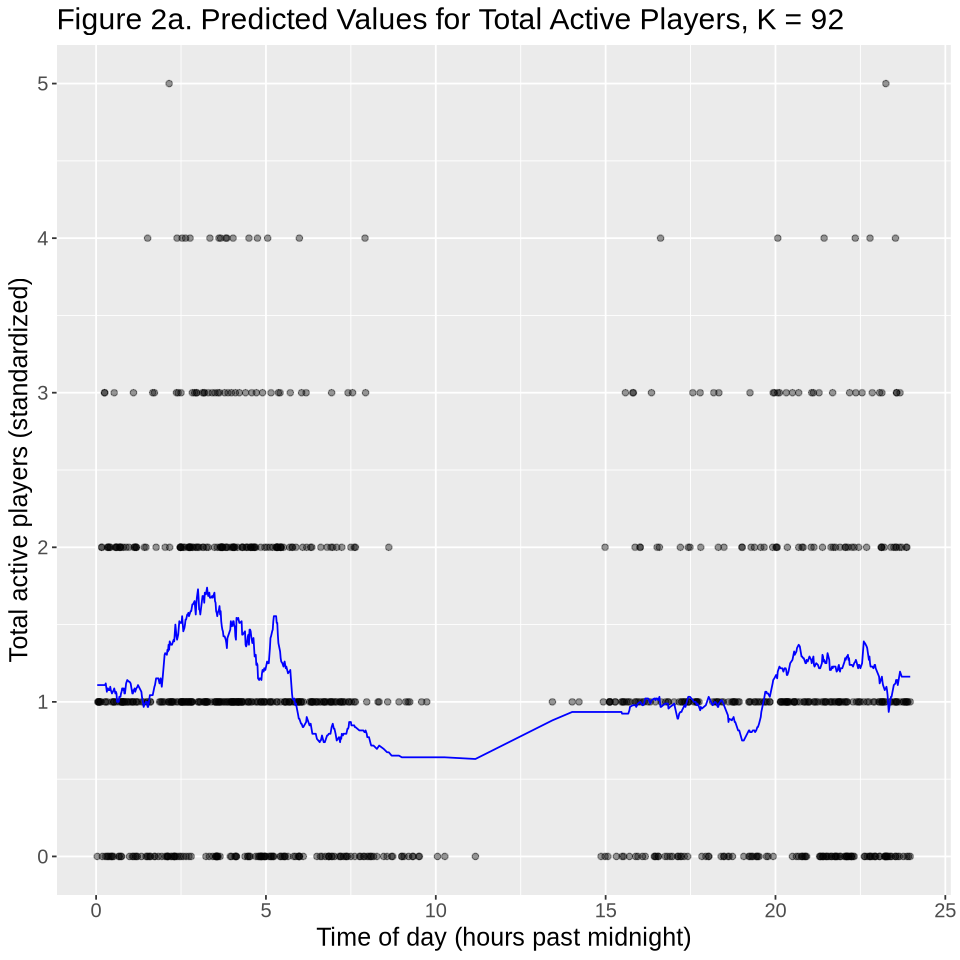

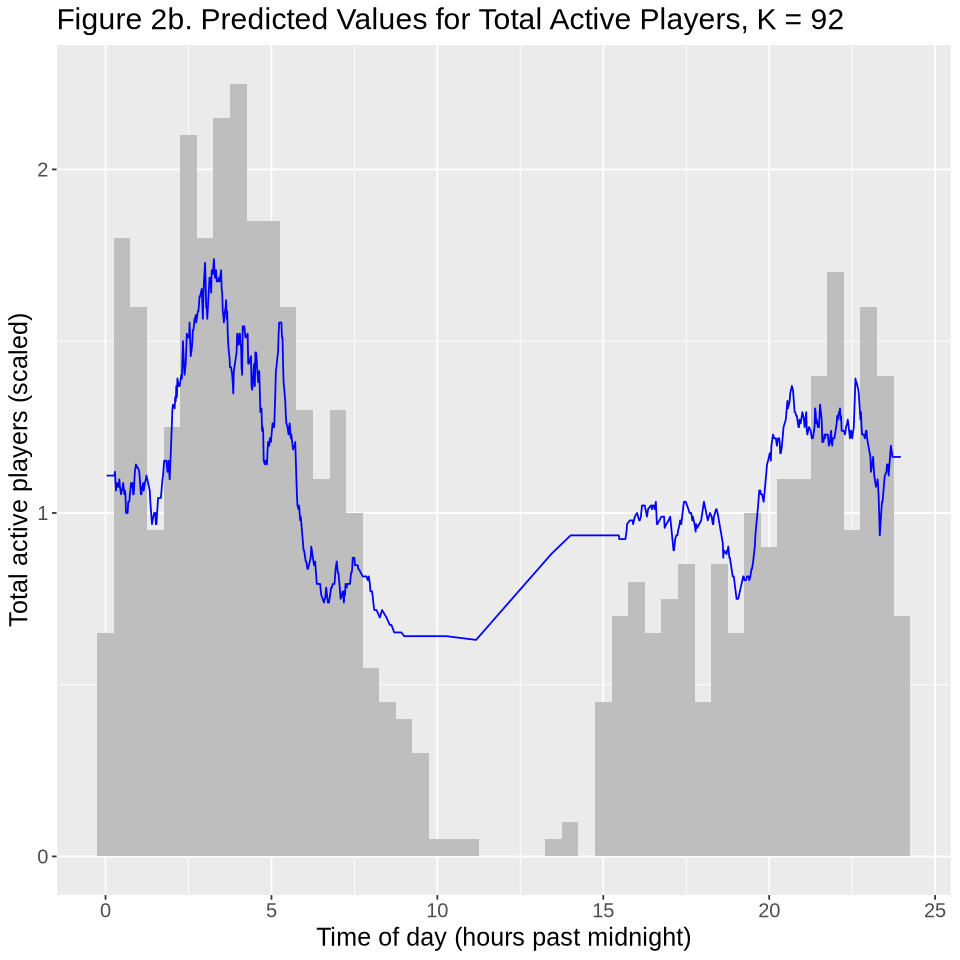

In [148]:
#Part 11: Prediction on Test Data and RMSPE value for model
players_prediction <- predict(player_fit, player_counts_by_time_test) |>
bind_cols(player_counts_by_time_test) |>
metrics(truth = total_active_players, estimate = .pred) |>
filter(.metric == "rmse")
players_prediction

#Part 12: Visualization of KNN regression model
players_pred <- predict(player_fit, player_counts_by_time_test) |>
bind_cols(player_counts_by_time_test)


regression_pred_visual <- players_pred |>
ggplot(aes(x = time_in_hours_past_midnight, y = total_active_players)) +
geom_point(alpha = 0.4) +
geom_line(data = players_pred,
          mapping = aes(x = time_in_hours_past_midnight, y = .pred),
          color = "blue") +
labs(x ="Time of day (hours past midnight)",
     y = "Total active players (standardized)",
     title = "Figure 2a. Predicted Values for Total Active Players, K = 92") +
scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
theme(text = element_text(size = 15))
regression_pred_visual

#Further Visualization of KNN regression model
regression_pred_visual <- players_pred |>
ggplot(aes(x = time_in_hours_past_midnight)) +
geom_histogram(binwidth = 0.5, aes(y = ..count.. *0.05), fill = "gray") +
geom_line(data = players_pred,
          mapping = aes(x = time_in_hours_past_midnight, y = .pred),
          color = "blue") +
labs(x ="Time of day (hours past midnight)",
     y = "Total active players (scaled)",
     title = "Figure 2b. Predicted Values for Total Active Players, K = 92") +
scale_y_continuous(breaks = seq(0, max(player_counts_by_time), by = 1)) +
theme(text = element_text(size = 15))
regression_pred_visual

# Discussion
### What We have Found


### Impact 

### Limitations, Future Questions and Further Research

A key limitaition is that we are only assesssing one explanatory variable: time of day. We have neglected to account for day-of-the-week and seasonal trends which can also influence the number of simultaneous active players.

KNN regression is normally applied with continuous numerical variables. Our variable is numeric but it is not continuous


*Limitations:*
- **Need to account for cyclical nature of time** via sin() and cos() transformations (0 and 23.99 hours-past-midnight should be considered adjacent in time rather than at extreme ends of linear scale like in graph)
- Less accurate extrapolations for times with less data


#### Group Member Contributions

|Name|Contribution|
|---|---|
|Adam Abdirahman Hassan|Code for KNN regression analysis and visualization; explanatation of code for KNN regression analysis|
|Alexandra Mykitiuk|Introduction; code for tidying, wrangling, and initial visualization of the data (retrieved from individual report); explanation of the code for tidying, wrangling and initial visualization of the data; editing of code explanation for KNN regression analysis|